In [23]:
%load_ext autoreload
%autoreload 2
import numpy as np
#import cosmodc2 as extract_cosmodc2
import lens_data as lens
import matplotlib.pyplot as plt
import GCRCatalogs
import healpy
from astropy.table import Table
import pickle,sys
import mysql
sys.path.append('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods/modules/')
from mysql.connector import Error
from clmm.dataops import compute_galaxy_weights
from clmm import Cosmology
from scipy.integrate import simps
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040)
cursor = conn.cursor(dictionary=True, buffered=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Lens catalog

## Cosmodc2 with qserv & GCRCatalogs

### true shapes, true redshifts

# DC2

In [24]:
%load_ext autoreload
%autoreload 2
from GCR import GCRQuery

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def load(filename, **kwargs):
    """Loads GalaxyCluster object to filename using Pickle"""
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)
tract_list = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/data_extraction/tract_dc2dr6_coord.pkl')

In [40]:
z, ra, dec = 0.1, 65, -35

In [41]:
object_cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_v2_with_addons')

In [62]:
def filters(zmin):
    r""" redshift + quality filters"""
    resolution_min = 0.2
    err_shape_max = 0.4
    
    object_basic_cuts = [
        GCRQuery('extendedness > 0'),     # Extended objects
        GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
        GCRQuery('xy_flag == 0'),                                      # Flag for bad centroid measurement
        GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag == 0'),            # Error code returned by shape measurement code
        GCRQuery((np.isfinite, 'ext_shapeHSM_HsmShapeRegauss_sigma')),] # Shape measurement uncertainty should not be NaN
    object_properties_cuts = [
        GCRQuery('snr_i_cModel > 9'),                              # SNR > 10
        GCRQuery('mag_i_cModel < 25'),                                 # cModel imag brighter than 24.5
        GCRQuery(f'ext_shapeHSM_HsmShapeRegauss_resolution >= {resolution_min}'), # Sufficiently resolved galaxies compared to PSF
        GCRQuery(f'ext_shapeHSM_HsmShapeRegauss_sigma <= {err_shape_max}'), 
        # New cut on blendedness:
        GCRQuery('blendedness < 10**(-0.375)'),                      # Avoid spurious detections and those contaminated by blends
        GCRQuery(f'photoz_mean > {0}'),
        #GCRQuery(f'photoz_mean < {zmax}')
        ]
    return  object_basic_cuts + object_properties_cuts

#quantities
def quantities():
    r"""quantities wanted"""
    quantity_label = ['id', 'ra', 'dec', 'mag_i_cModel','snr_i_cModel', 'mag_i']
    quantity_wanted_HSM_Metacal = ['ext_shapeHSM_HsmShapeRegauss_e2',
                           'ext_shapeHSM_HsmShapeRegauss_e1',
                           'ext_shapeHSM_HsmShapeRegauss_sigma', 
                           'ext_shapeHSM_HsmShapeRegauss_resolution',]
                         # 'mcal_g1', 'mcal_g2', 'mcal_gauss_g1','mcal_gauss_g1', 'mcal_psf_g1', 'mcal_psf_g2']
    quantity_wanted_photozs = ['photoz_mean', 'photoz_pdf','photoz_odds']
    return  quantity_label + quantity_wanted_HSM_Metacal + quantity_wanted_photozs

In [63]:
import extract_in_dc2 as dc2
rmax=2
distance_to_cluster = cosmo.eval_da(z)
theta_max = (rmax/distance_to_cluster) * (180./np.pi)
tracts=dc2.neighboring_tract(ra, dec, theta_max)

In [64]:
tracts

4030


In [65]:
coord_filters = [f'({ra} - ra)**2 *cos({dec}*{np.pi}/180)**2 + (dec - {dec})**2 <= {theta_max}**2']
cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_v2_with_addons')
z_bins= cat.photoz_pdf_bin_centers
object_data =cat.get_quantities(quantities(), filters=(coord_filters + filters(z)),
                                                native_filters = ['tract == ' + str(tracts[0])])

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


In [66]:
object_data = Table(object_data)

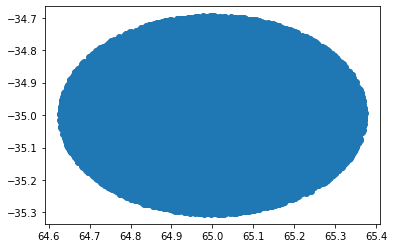

In [67]:
plt.scatter(object_data['ra'], object_data['dec'])

##### 

In [68]:
theta_arcmin = 3437.75*(rmax/cosmo.eval_da_z1z2(0, z))

In [69]:
S_arcmin2 =np.pi*theta_arcmin**2

In [70]:
mag_i_list = np.linspace(24, 28, 10)

In [71]:
snr = np.linspace(0, 30, 30)

In [72]:
masks=[object_data['snr_i_cModel'] > i for i in snr]

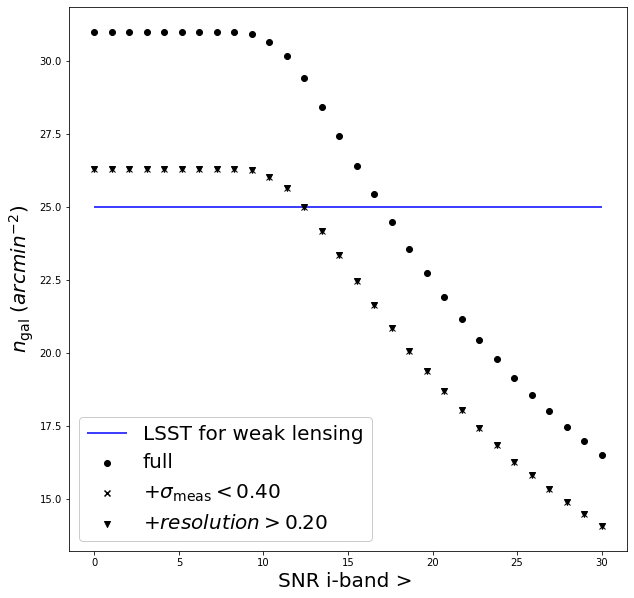

In [75]:
plt.figure(figsize=(10,10))
plt.hlines(25, 0, 30, color='b', label='LSST for weak lensing')
for i,mask in enumerate(masks):
    n_gal_arcmin2=len(object_data[mask])/S_arcmin2
    plt.plot(snr[i], n_gal_arcmin2 ,'o', color='k')
    #redshift window
    res_min = .2
    err_meas_max = .4
    mask = mask * ( object_data['photoz_mean'] <= 1.4)*(object_data['photoz_mean'] >= .2)
    #shape measurement error
    mask = mask *( object_data['ext_shapeHSM_HsmShapeRegauss_sigma'] <= err_meas_max)#label = f'{n_gal_arcmin2}')
    n_gal_arcmin2=len(object_data[mask])/S_arcmin2
    plt.plot(snr[i], n_gal_arcmin2 ,'x', color='k')
    #resolution
    mask = mask *( object_data['ext_shapeHSM_HsmShapeRegauss_resolution'] >= res_min)#label = f'{n_gal_arcmin2}')
    n_gal_arcmin2=len(object_data[mask])/S_arcmin2
    plt.plot(snr[i], n_gal_arcmin2 ,'v',  color='k')
plt.scatter([],[], marker='o', label='full', c='k')
plt.scatter([],[], marker='x', label=r'$+\sigma_{\rm meas} <$'+ f'{err_meas_max:.2f}',c='k')
plt.scatter([],[], marker='v', label=r'$+ resolution >$'+ f'{res_min:.2f}', c='k')
plt.xlabel(r'SNR i-band > ', fontsize=20)
plt.ylabel(r'$n_{\rm gal}$ $(arcmin^{-2})$', fontsize=20)
plt.legend(framealpha=1, fontsize=20)